## Лабораторная работа 4. Решающие деревья

В этой домашке мы будем работать с набором данных с платформы kaggle в формате соревнования и по ходу этой и следующей лабораторной работы узнаем как правильно организовать решение соревнования, чтобы удобно было воспользоваться техниками ансамблирования решений и адекватно оценить какие идеи в нашем решении привели к улучшениям нашего итогового результата.

Кроме того, в этой домашке мы познакомимся с новыми классами моделей — деревьями и случайными лесами.

План такой:
* Пишем новые модели, над которыми будем экспериментировать
* Пишем пайплайн для ведения и сравнения экспериментов
* Мучаем наши новые модели и модели, которые мы уже знаем, для достижения высокого качества на тестовой выборке
* Применяем ансамблирование и получаем топовый результат

Ссылка на Контест:
https://contest.yandex.ru/contest/68192/

**1. (1 балл)** Загрузите в Контест решение первой задачи (см. файл `src.py`).

**2. (1 балл)** Загрузите в Контест решение второй задачи (см. файл `src.py`).

**3. (2 балла)** Загрузите в Контест решение третьей задачи (см. файл `src.py`).

**4. (2 балла)** Загрузите в Контест решение четвёртой задачи (см. файл `src.py`).

In [1]:
import contextlib
import enum
import json
import os
import pathlib
import typing as tp
import uuid


import numpy as np
import typing as tp
import enum
from collections import Counter
from scipy.stats import mode
from collections import defaultdict

class NodeType(enum.Enum):
   REGULAR = 1
   TERMINAL = 2

In [2]:
# The Gini index is the probability that two objects from a data set are of different classes.
def gini(y: np.ndarray) -> float:
    """
    Computes Gini index for given set of labels
    :param y: labels
    :return: Gini impurity
    """
    counter = Counter(y)
    len_y = len(y)
    gini_index = 1 - np.sum([(p / len_y) ** 2 for p in counter.values()])
    return gini_index

In [3]:
def weighted_impurity(y_left: np.ndarray, y_right: np.ndarray) -> \
        tp.Tuple[float, float, float]:
    """
    Computes weighted impurity by averaging children impurities
    :param y_left: left  partition
    :param y_right: right partition
    :return: averaged impurity, left child impurity, right child impurity
    """
    n_left, n_right = len(y_left), len(y_right)
    n = n_left + n_right
    left_impurity = gini(y_left)
    right_impurity = gini(y_right)
    weighted_impurity = left_impurity * (n_left / n) + right_impurity * (n_right / n)
    return weighted_impurity, left_impurity, right_impurity

In [4]:
def create_split(feature_values: np.ndarray, threshold: float) -> tp.Tuple[np.ndarray, np.ndarray]:
    """
    splits given 1-d array according to relation to threshold into two subarrays
    :param feature_values: feature values extracted from data
    :param threshold: value to compare with
    :return: two sets of indices
    """
    left_idx = np.where(feature_values <= threshold)[0]
    right_idx = np.where(feature_values > threshold)[0]
    return left_idx, right_idx

In [5]:
class MyDecisionTreeNode:
    """
    Auxiliary class serving as representation of a decision tree node
    """

    def __init__(
            self,
            meta: 'MyDecisionTreeClassifier',
            depth,
            node_type: NodeType = NodeType.REGULAR,
            predicted_class: tp.Optional[tp.Union[int, str]] = None,
            left_subtree: tp.Optional['MyDecisionTreeNode'] = None,
            right_subtree: tp.Optional['MyDecisionTreeNode'] = None,
            feature_id: int = None,
            threshold: float = None,
            impurity: float = np.inf
    ):
        """

        :param meta: object, holding meta information about tree
        :param depth: depth of this node in a tree (is deduced on creation by depth of ancestor)
        :param node_type: 'regular' or 'terminal' depending on whether this node is a leaf node
        :param predicted_class: class label assigned to a terminal node
        :param feature_id: index if feature to split by
        :param
        """
        self._node_type = node_type
        self._meta = meta
        self._depth = depth
        self._predicted_class = predicted_class
        self._class_proba = None
        self._left_subtree = left_subtree
        self._right_subtree = right_subtree
        self._feature_id = feature_id
        self._threshold = threshold
        self._impurity = impurity
        self._classes = None

    def _best_split(self, X: np.ndarray, y: np.ndarray):
        """
        finds best split
        :param X: Data, passed to node
        :param y: labels
        :return: best feature, best threshold, left child impurity, right child impurity
        """
        lowest_impurity = np.inf
        best_feature_id = None
        best_threshold = None
        lowest_left_child_impurity, lowest_right_child_impurity = None, None
        features = self._meta.rng.permutation(X.shape[1])
        for feature in features:
            current_feature_values = X[:, feature]
            thresholds = np.unique(current_feature_values)
            for threshold in thresholds:
               left_idx, right_idx = create_split(current_feature_values, threshold)
               current_weighted_impurity, current_left_impurity, current_right_impurity = weighted_impurity(y[left_idx], y[right_idx]) # calcualte impurity for given indices
               if current_weighted_impurity < lowest_impurity:
                    lowest_impurity = current_weighted_impurity
                    best_feature_id = feature
                    best_threshold = threshold
                    lowest_left_child_impurity = current_left_impurity
                    lowest_right_child_impurity = current_right_impurity

        return best_feature_id, best_threshold, lowest_left_child_impurity, lowest_right_child_impurity

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        recursively fits a node, providing it with predicted class or split condition
        :param X: Data
        :param y: labels
        :return: fitted node
        """
        if self._meta.root._classes is None:
            self._classes = {val: ind for ind, val in enumerate(sorted(np.unique(y)))}
        node_max_depth = self._meta.max_depth if self._meta.max_depth else float('inf')
        if len(set(y)) == 1 or self._depth >=  node_max_depth or len(y) < self._meta.min_samples_split:
            self._node_type = NodeType.TERMINAL
            counter = Counter(y)
            n_leaf = len(y)
            self._predicted_class = counter.most_common(1)[0][0]
            self._class_proba = np.zeros(self._meta._n_classes)
            for val, count in counter.items():
                index = self._meta.root._classes[val]
                self._class_proba[index] = count / n_leaf
            return self
        self._feature_id, self._threshold, left_imp, right_imp = self._best_split(X, y)
        left_idx, right_idx = create_split(X[:, self._feature_id], self._threshold)
        self._left_subtree = MyDecisionTreeNode(
            meta=self._meta,
            depth=self._depth + 1,  # adjust depth
            impurity=left_imp
        ).fit(
            X[left_idx],
            y[left_idx]
        )
        self._right_subtree = MyDecisionTreeNode(
            meta=self._meta,
            depth=self._depth + 1,  # adjust depth
            impurity=right_imp
        ).fit(
            X[right_idx],
            y[right_idx]
        )
        return self

    def predict(self, x: np.ndarray):
        """
        Predicts class for a single object
        :param x: object of shape (n_features, )
        :return: class assigned to object
        """
        if self._node_type is NodeType.TERMINAL:
            return self._predicted_class
        if x[self._feature_id] <= self._threshold:
            return self._left_subtree.predict(x)
        else:
            return self._right_subtree.predict(x)

    def predict_proba(self, x: np.ndarray):
        """
        Predicts probability for a single object
        :param x: object of shape (n_features, )
        :return: vector of probabilities assigned to object
        """
        if self._node_type is NodeType.TERMINAL:
            return self._class_proba
        if x[self._feature_id] <= self._threshold:
            return self._left_subtree.predict_proba(x)
        else:
            return self._right_subtree.predict_proba(x)

In [6]:
class MyDecisionTreeClassifier:
    """
    Class analogous to sklearn implementation of decision tree classifier with Gini impurity criterion,
    named in a manner avoiding collisions
    """

    def __init__(
            self,
            max_depth: tp.Optional[int] = None,
            min_samples_split: tp.Optional[int] = 2,
            seed: int = 0,
    ):
        """
        :param max_depth: maximal depth of tree, prevents overfitting
        :param min_samples_split: minimal amount of samples for node to be a splitter node
        :param seed: seed for RNG, enables reproducibility
        """
        self.root = MyDecisionTreeNode(self, 1)
        self._is_trained = False
        self.max_depth = max_depth or np.inf
        self.min_samples_split = min_samples_split or 2
        self.rng = np.random.default_rng(seed)
        self._n_classes = 0

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        starts recursive process of node criterion fitting from the root
        :param X: Data
        :param y: labels
        :return: fitted self
        """
        self._n_classes = np.unique(y).shape[0]
        self.root.fit(X, y)
        self._is_trained = True
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts class for a sequence of objects
        :param x: Data
        :return: classes assigned to each object
        """
        if not self._is_trained:
            raise RuntimeError('predict call on untrained model')
        else:
            return np.array([self.root.predict(x) for x in X])

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts class for a sequence of objects
        :param x: Data
        :return: probabilities of all classes for each object
        """
        if not self._is_trained:
            raise RuntimeError('predict call on untrained model')
        else:
            return np.array([self.root.predict_proba(x) for x in X])

My code for MyRandomForestClassifier which works on real data

In [7]:
class MyRandomForestClassifier:
    """
    Data-diverse ensemble of tree calssifiers
    """
    big_number = 1 << 32

    def __init__(
            self,
            n_estimators: int,
            max_depth: tp.Optional[int] = None,
            min_samples_split: tp.Optional[int] = 2,
            seed: int = 0
    ):
        """
        :param n_estimators: number of trees in forest
        :param max_depth: maximal depth of tree, prevents overfitting
        :param min_samples_split: minimal amount of samples for node to be a splitter node
        :param seed: seed for RNG, enables reproducibility
        """
        self._n_estimators = n_estimators
        self.subclasses = defaultdict(list)
        self._classes = None
        self._n_classes = 0
        self._is_trained = False
        self.rng = np.random.default_rng(seed)
        self.estimators = [
            MyDecisionTreeClassifier(max_depth, min_samples_split, seed=seed) for
            seed in self.rng.choice(max(MyRandomForestClassifier.big_number, n_estimators), size=(n_estimators,),
                                    replace=False)]

    def _bootstrap_sample(self, X: np.ndarray, y: np.ndarray, index=0):
        """
        returns bootstrapped sample from X of equal size
        :param X: objects collection to sample from
        :param y: corresponding labels
        :return:
        """
        n = X.shape[0]
        indices = self.rng.choice(n, size=(n,))  # bootstrap indices with equal probability from X
        self.subclasses[index] = sorted(np.unique(y[indices]))
        return X[indices], y[indices]

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        fits each estimator of the ensemble on the bootstrapped data sample
        :param X: Data
        :param y: labels
        :return: fitted self
        """
        if self._classes is None:
            self._classes = {val: ind for ind, val in enumerate(sorted(np.unique(y)))}
        self._n_classes = np.unique(y).shape[0]
        for i in range(self._n_estimators):
            self.estimators[i] = self.estimators[i].fit(*self._bootstrap_sample(X, y, index=i))
        self._is_trained = True
        return self

    def predict_proba(self, X: np.ndarray):
        """
        predict probability of each class by averaging over all base estimators
        :param X: Data
        :return: array of probabilities
        """
        probas = np.zeros((X.shape[0], self._n_classes))
        for e, estimator in enumerate(self.estimators):
            pred_proba = estimator.predict_proba(X)
            if pred_proba.shape[1] < self._n_classes:
                full_proba = np.zeros((X.shape[0], self._n_classes))
                for i, subclass in enumerate(self.subclasses[e]):
                    index = self._classes[subclass]
                    full_proba[:, index] = pred_proba[:, i]
                pred_proba = full_proba
            probas += pred_proba
        probas /= self._n_estimators
        return probas

    def predict(self, X):
        """
        predict class for each object
        :param X: Data
        :return: array of class labels
        """
        predictions = np.zeros(X.shape[0])
        for ind, x in enumerate(X):
            x = x.reshape(len(x), -1)
            predictions[ind] = mode(np.array([estimator.predict(x) for estimator in self.estimators])).mode[0]
        return predictions # most probable class for each object

In [8]:
clf = MyRandomForestClassifier(100)
X = np.random.normal(0, 1, (100, 1))
y = np.arange(0, 100)
clf.fit(X, y)

In [9]:
clf.predict_proba(X)

array([[0.65, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.65, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.72, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.69, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.69, 0.  ],
       [0.  , 0.  , 0.28, ..., 0.  , 0.  , 0.67]])

In [10]:
clf.predict(X)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

Code which pass the test from YSDA

In [11]:
class MyRandomForestClassifier:
    """
    Data-diverse ensemble of tree calssifiers
    """
    big_number = 1 << 32

    def __init__(
            self,
            n_estimators: int,
            max_depth: tp.Optional[int] = None,
            min_samples_split: tp.Optional[int] = 2,
            seed: int = 0
    ):
        """
        :param n_estimators: number of trees in forest
        :param max_depth: maximal depth of tree, prevents overfitting
        :param min_samples_split: minimal amount of samples for node to be a splitter node
        :param seed: seed for RNG, enables reproducibility
        """
        self._n_estimators = n_estimators
        self.subclasses = defaultdict(list)
        self._classes = None
        self._n_classes = 0
        self._is_trained = False
        self.rng = np.random.default_rng(seed)
        self.estimators = [
            MyDecisionTreeClassifier(max_depth, min_samples_split, seed=seed) for
            seed in self.rng.choice(max(MyRandomForestClassifier.big_number, n_estimators), size=(n_estimators,),
                                    replace=False)]

    def _bootstrap_sample(self, X: np.ndarray, y: np.ndarray):
        """
        Returns bootstrapped sample from X of equal size
        :param X: objects collection to sample from
        :param y: corresponding labels
        :return: tuple of bootstrapped X and y
        """
        indices = self.rng.integers(0, len(X), len(X))
        return X[indices], y[indices]

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fits each estimator of the ensemble on the bootstrapped data sample
        :param X: Data
        :param y: labels
        :return: fitted self
        """
        self._n_classes = np.unique(y).shape[0]
        for estimator in self.estimators:
            X_sample, y_sample = self._bootstrap_sample(X, y)
            estimator.fit(X_sample, y_sample)
        self._is_trained = True
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict probability of each class by averaging over all base estimators
        :param X: Data
        :return: array of probabilities
        """
        probas = np.zeros((X.shape[0], self._n_classes))
        for estimator in self.estimators:
            probas += estimator.predict_proba(X)
        return probas / len(self.estimators)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict class for each object
        :param X: Data
        :return: array of class labels
        """
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [46]:
class Logger:
    """Logger performs data management and stores scores and other relevant information"""

    def __init__(self, logs_path: tp.Union[str, os.PathLike]):
        self.path = pathlib.Path(logs_path)

        records = []
        for root, dirs, files in os.walk(self.path):
            for file in files:
                if file.lower().endswith('.json'):
                    uuid = os.path.splitext(file)[0]
                    with open(os.path.join(root, file), 'r') as f:
                        try:
                            logged_data = json.load(f)
                            records.append(
                                {
                                    'id': uuid,
                                    **logged_data
                                }
                            )
                        except json.JSONDecodeError:
                            pass
        if records:
            self.leaderboard = pd.DataFrame.from_records(records, index='id')
        else:
            self.leaderboard = pd.DataFrame(index=pd.Index([], name='id'))

        self._current_run = None

    class Run:
        """Run incapsulates information for a particular entry of logged material. Each run is solitary experiment"""

        def __init__(self, name, storage, path):
            self.name = name
            self._storage = storage
            self._path = path
            new_series = pd.Series(name=name)
            self._storage = pd.concat([self._storage, new_series.to_frame().T], ignore_index=True)
            #self._storage.append(pd.Series(name=name))

        def log(self, key, value):
            self._storage.loc[self.name, key] = value

        def log_values(self, log_values: tp.Dict[str, tp.Any]):
            for key, value in log_values.items():
                self.log(key, value)

        def save_logs(self):
            with open(self._path / f'{self.name}.json', 'w+') as f:
                json.dump(self._storage.loc[self.name].to_dict(), f)

        def log_artifact(self, fname: str, writer: tp.Callable):
            with open(self._path / fname, 'wb+') as f:
                writer(f)

    @contextlib.contextmanager
    def run(self, name: tp.Optional[str] = None):
        if name is None:
            name = str(uuid.uuid4())
        # elif name in self.leaderboard.index:
        #     raise NameError("Run with given name already exists, name should be unique")
        else:
            name = name.replace(' ', '_')
        self._current_run = Logger.Run(name, self.leaderboard, self.path / name)
        os.makedirs(self.path / name, exist_ok=True)
        try:
            yield self._current_run
        finally:
            self._current_run.save_logs()


def load_predictions_dataframe(filename, column_prefix, index):
    with open(filename, 'rb') as file:
        data = np.load(file)
        dataframe = pd.DataFrame(data, columns=[f'{column_prefix}_{i}' for i in range(data.shape[1])],
                                 index=index)
        return dataframe

In [47]:
def load_predictions_dataframe(filename, column_prefix, index):
    with open(filename, 'rb') as file:
        data = np.load(file)
        dataframe = pd.DataFrame(data, columns=[f'{column_prefix}_{i}' for i in range(data.shape[1])],
                                 index=index)
        return dataframe


In [48]:
import pandas as pd
from sklearn.metrics import check_scoring
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection._validation import _score

class ExperimentHandler:
    """This class perfoms experiments with given model, measures metrics and logs everything for thorough comparison"""
    stacking_prediction_filename = 'cv_stacking_prediction.npy'
    test_stacking_prediction_filename = 'test_stacking_prediction.npy'

    def __init__(
            self,
            X_train: pd.DataFrame,
            y_train: pd.Series,
            X_test: pd.DataFrame,
            y_test: pd.Series,
            cv_iterable: tp.Union[sklearn.model_selection.KFold, tp.Iterable],
            logger: Logger,
            metrics: tp.Dict[str, tp.Union[tp.Callable, str]],
            n_jobs=-1
    ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self._cv_iterable = cv_iterable
        self.logger = logger
        self._metrics = metrics
        self._n_jobs = n_jobs

    def score_test(self, estimator, metrics, run, test_data=None):
        """
        Computes scores for test data and logs them to given run
        :param estimator: fitted estimator
        :param metrics: metrics to compute
        :param run: run to log into
        :param test_data: optional argument if one wants to pass augmented test dataset
        :return: None
        """
        if test_data is None:
            test_data = self.X_test
        test_scores = {
            metric_name: metric_func(estimator, test_data, self.y_test)
            for metric_name, metric_func in metrics.items()
        }
        run.log_values({key + '_test': value for key, value in test_scores.items()})
        # if test_data is None:
        #     test_data = self.X_test
        # test_scores = _score(estimator, test_data, self.y_test, metrics, score_params=None)
        # run.log_values({key + '_test': value for key, value in test_scores.items()})

    def score_cv(self, estimator, metrics, run):
        """
        computes scores on cross-validation
        :param estimator: estimator to fit
        :param metrics: metrics to compute
        :param run: run to log to
        :return: None
        """
        cross_val_results = dict()
        for name, metric in metrics.items():
            cross_val_results[f"test_{name}"] = cross_val_score(estimator, self.X_train, self.y_train, scoring=metric, cv=self._cv_iterable, n_jobs=self._n_jobs)  # compute crossval scores (easier done using corresponding sklearn method)
        for key, value in cross_val_results.items():
            if key.startswith('test_'):
                metric_name = key.split('_', maxsplit=1)[1]
                mean_score = np.mean(value)
                std_score = np.std(value)
                run.log_values(
                    {
                        metric_name + '_mean': mean_score,
                        metric_name + '_std': std_score
                    }
                )

    def generate_stacking_predictions(self, estimator, run):
        """
        generates predictions over cross-validation folds, then saves them as artifacts
        returns fitted estimator for convinience and les train overhead
        :param estimator: estimator to use
        :param run: run to log to
        :return: estimator fitted on train, stacking cross-val predictions, stacking test predictions
        """
        if hasattr(estimator, "predict_proba"):  # choose the most informative method for stacking predictions
            method = "predict_proba"
        elif hasattr(estimator, "decision_function"):
            method = "decision_function"
        else:
            method = "predict"
        cross_val_stacking_prediction = cross_val_predict(estimator, self.X_train, self.y_train, cv=self._cv_iterable, method=method, n_jobs=self._n_jobs)  # generate crossval predictions for stacking using most informative method
        run.log_artifact(ExperimentHandler.stacking_prediction_filename,
                         lambda file: np.save(file, cross_val_stacking_prediction))
        estimator.fit(self.X_train, self.y_train)
        test_stacking_prediction = getattr(estimator, method)(self.X_test)
        run.log_artifact(ExperimentHandler.test_stacking_prediction_filename,
                         lambda file: np.save(file, test_stacking_prediction))
        return estimator, cross_val_stacking_prediction, test_stacking_prediction

    def get_metrics(self, estimator):
        """
        get callable metrics with estimator validation
        (e.g. estimator has predict_proba necessary for likelihood computation, etc)
        """
        return {metric: check_scoring(estimator, metric) for metric in self._metrics}

    def run(self, estimator: sklearn.base.BaseEstimator, name=None):
        """
        perform run for given estimator
        :param estimator: estimator to use
        :param name: name of run for convinience and consitent logging
        :return: leaderboard with conducted run
        """
        metrics = self.get_metrics(estimator)
        with self.logger.run(name=name) as run:
            if run.name not in self.logger.leaderboard.index:
                self.logger.leaderboard.loc[run.name] = {}
            # compute predictions over cross-validation
            self.score_cv(estimator, metrics, run)
            fitted_on_train, _, _ = self.generate_stacking_predictions(estimator, run)
            self.score_test(fitted_on_train, metrics, run, test_data=self.X_test)
            return self.logger.leaderboard.loc[[run.name]]
    def get_stacking_predictions(self, run_names):
        """
        :param run_names: run names for which to extract stacking predictions for averaging and stacking
        :return: dataframe with predictions indexed by run names
        """
        train_dataframes = []
        test_dataframes = []
        for run_name in run_names:
            train_filename = self.logger.path / run_name / ExperimentHandler.stacking_prediction_filename
            train_dataframes.append(load_predictions_dataframe(filename=train_filename, column_prefix=run_name,
                                                               index=self.X_train.index))
            test_filename = self.logger.path / run_name / ExperimentHandler.test_stacking_prediction_filename
            test_dataframes.append(load_predictions_dataframe(filename=test_filename, column_prefix=run_name,
                                                              index=self.X_test.index))

        return pd.concat(train_dataframes, axis=1), pd.concat(test_dataframes, axis=1)



#### 5. (2 балла) Решающее дерево
Допишите `sklearn`-совместимый класс `MyDecisionTreeClassifier` в `src.py`, убедитесь, что он проходит тесты в проверяющей системе.

In [15]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

Мы хотим посмотреть на него в картинках, так что воспользуемся удобной библиотечкой `mlxtend`, которая позволяет взмахом руки получать подробные графики работы модели.

In [16]:
!pip install mlxtend

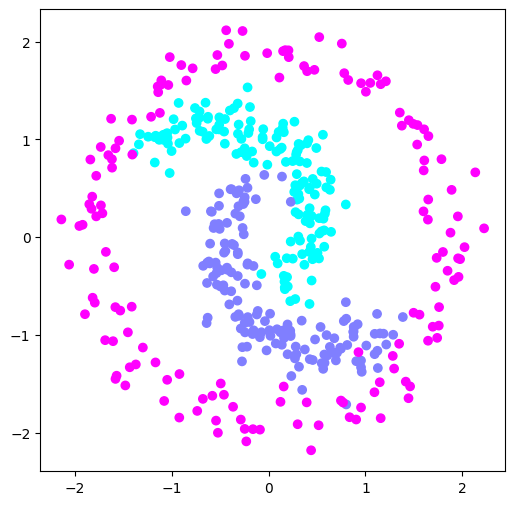

In [17]:
def make_sunny_moons(n_sun=50, n_moons=100, noise=0.0, sun_radius=1.9, theta=None):
    X_moons, y_moons = make_moons(n_samples=n_moons, noise=noise, random_state=0xC0FFEE)
    if not n_sun:
        return X_moons, y_moons

    rng = np.random.default_rng(0xC0FFEE)
    angles = np.arange(0, 2 * np.pi, 2 * np.pi / n_sun)
    X_sun = sun_radius * np.column_stack([np.cos(angles), np.sin(angles)]) + np.array([0.5, 0.25])
    X_sun += rng.normal(scale=noise, size=X_sun.shape)
    y_sun = 2 * np.ones(n_sun)

    X = np.vstack([X_moons, X_sun])
    y = np.concatenate([y_moons, y_sun]).astype(int)
    X -= X.mean(axis=0)

    if theta is None:
        theta = np.pi / 4
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    X = X @ R

    return X, y

X, y = make_sunny_moons(n_sun=150, n_moons=300, noise=0.15)
_ = plt.figure(figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='cool')
plt.show();

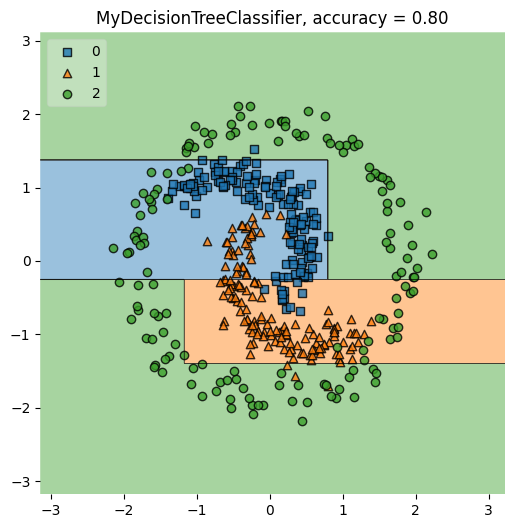

In [18]:
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score

def make_clf_plot(classifier, axis):
    classifier.fit(X, y)
    plot_decision_regions(X, y, clf=classifier, legend=2, ax=axis)
    accuracy = accuracy_score(y, classifier.predict(X))
    axis.set_title(f"{classifier.__class__.__name__}, accuracy = {accuracy:2.2f}")

_ = plt.figure(figsize=(6, 6))
axis = plt.axes()
make_clf_plot(MyDecisionTreeClassifier(max_depth=4, seed=42), axis)

Поменяйте параметры дерева — глубину или минимальное количество сэмплов для сплита, посмотрите на картинки и значения точности для этих случаев

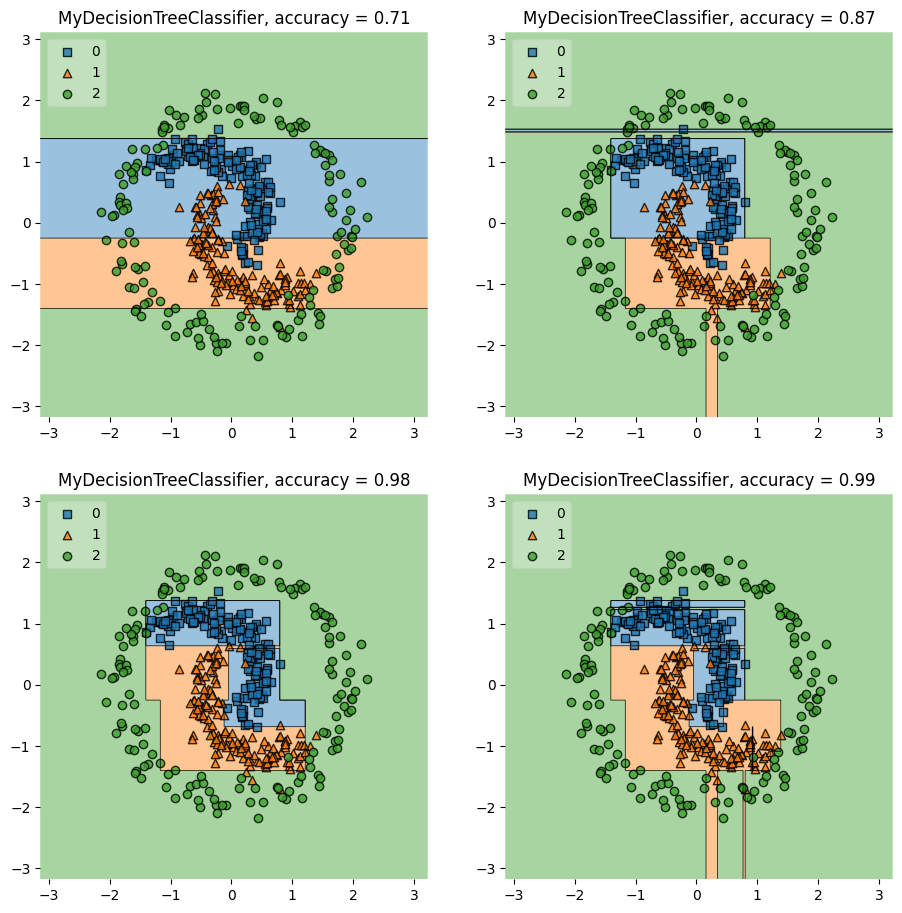

In [19]:
cases = [
    MyDecisionTreeClassifier(max_depth=3, seed=42),
    MyDecisionTreeClassifier(max_depth=5, seed=42),
    MyDecisionTreeClassifier(max_depth=None, min_samples_split=20, seed=42),
    MyDecisionTreeClassifier(max_depth=None, min_samples_split=5, seed=42),
]

def make_clf_plot(classifier, axis):
    classifier.fit(X, y)
    plot_decision_regions(X, y, clf=classifier, legend=2, ax=axis)
    accuracy = accuracy_score(y, classifier.predict(X))
    axis.set_title(f"{classifier.__class__.__name__}, accuracy = {accuracy:2.2f}")

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11, 11))

for classifier, axis in zip(cases, axes.flat):
    make_clf_plot(classifier, axis)

##### Делаем красиво с помощью фича-инжиниринга

Воспользуйтесь пайплайнами (`Pipeline`) из `sklearn`, чтобы предобработать наши признаки для получения более информативных и достигните высокого качества на обучающей выборке с маленькой глубиной дерева и сравните с линейной моделью на нелинейных признаках

In [20]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

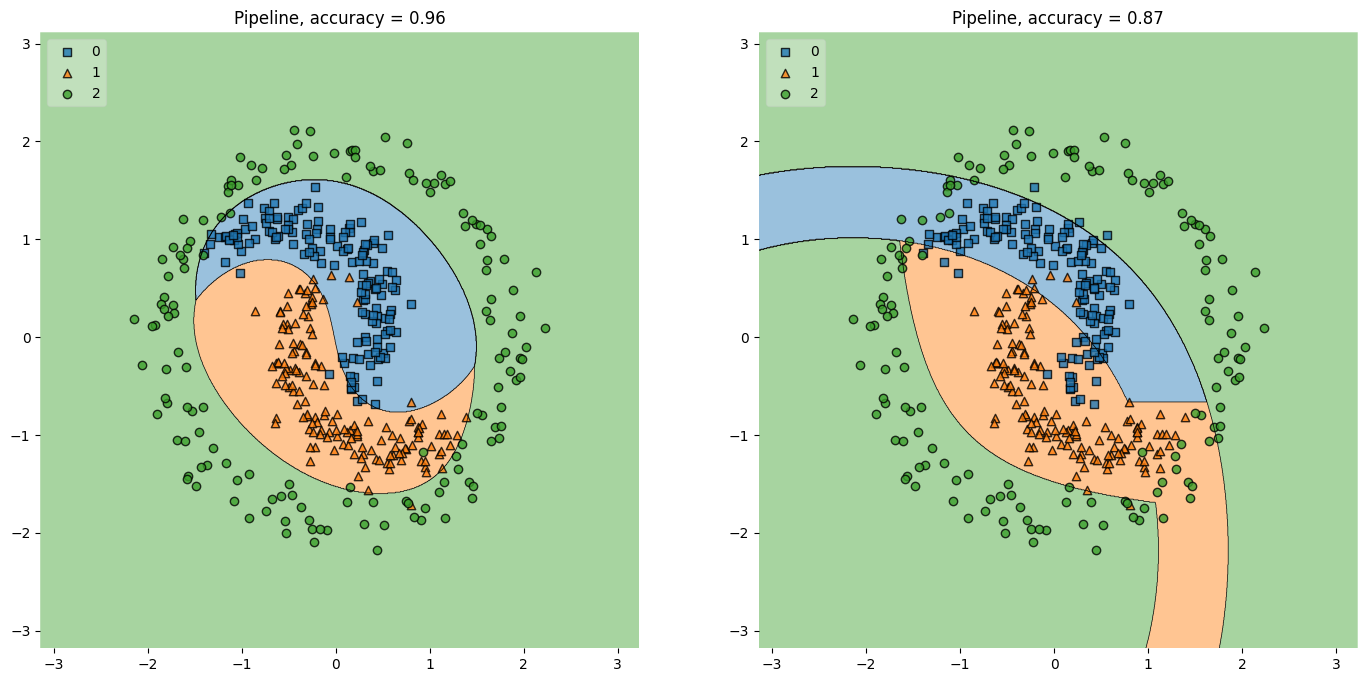

In [21]:
logreg_pipeline = Pipeline([
    ('feature_generation', FeatureUnion([
        ('sine', FunctionTransformer(np.sin)),
        ('cosine', FunctionTransformer(np.cos)),
        ('id', FunctionTransformer())
    ])),
    ('polynomial', PolynomialFeatures(2)),
    ('standartization', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42)),
])

tree_pipeline = Pipeline([
    ('standartization', MinMaxScaler()),
    ('feature_generation', FeatureUnion([
        ('sine', FunctionTransformer(np.sin)),
        ('cosine', FunctionTransformer(np.cos)),
        ('id', FunctionTransformer())
    ])),
    ('polynomial', PolynomialFeatures(2)),
    ('tree', MyDecisionTreeClassifier(max_depth=4, seed=42)),
])

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(17, 8))

for classifier, axis in zip((logreg_pipeline, tree_pipeline), axes):
    make_clf_plot(classifier, axis)

##### 6. (2 балла) Случайный лес
Допишите `sklearn`-совместимый класс `MyRandomForestClassifier` в `src.py`, убедитесь, что он проходит тесты в проверяющей системе.\
Посмотрите как он работает на сгенерированных данных, наблюдается ли улучшение от ансамблирования?

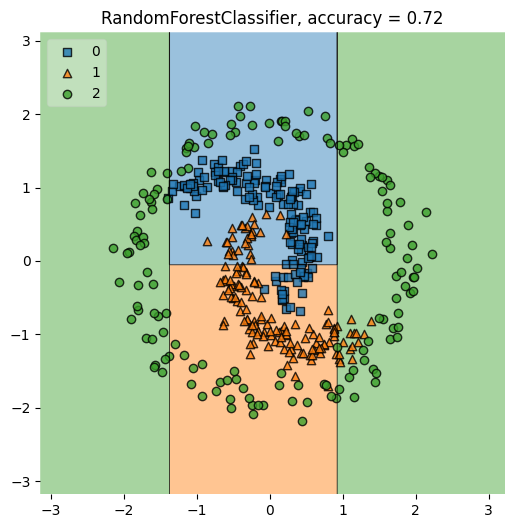

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
_ = plt.figure(figsize=(6, 6))
axis = plt.axes()
make_clf_plot(RandomForestClassifier(n_estimators=1, max_depth=3), axis)

*Ниже можно использовать `DecisionTreeClassifier` и `RandomForestClassifier` из `sklearn`, поскольку они имплементированы на `Cython`* $=>$ *работают быстрее и обладают большим числом настраиваемых параметров.*

#### Серьезные данные
##### Получаем датасет

Ссылка на публичный датасет https://www.kaggle.com/purumalgi/music-genre-classification \
Ознакомьтесь с описанием, поймите о какой задаче и каких данных идет речь, можно удовлетворить некоторое любопытство в `Data Explorer'e`, но в целом мы разберемся с этим по ходу ноутбука \
Мы сразу научимся работать с данными на kaggle (почти) без использования графического интерфейса при помощи kaggle-api, это полезно, например, если нам надо залить данные на сервер с консольным доступом и обработать их там.

Если у вас менеджер пакетов pip, то запустите эту команду из того же окружения то и юпитер-ноутбук (например в новой ячейке) \
`!pip install kaggle` \
Если conda, то вот эту \
`!conda install -c conda-forge kaggle`

In [23]:
!pip install kaggle

Теперь ваша задача зайти в свой аккаунт в kaggle (создайте, если его еще нет) и создать API токен, чтобы авторизовать все действия из командной строки, такие как загрузка датасета или ноутбука. Подробная инструкция есть тут https://github.com/Kaggle/kaggle-api#api-credentials \
Когда ваш токен готов, полложите `kaggle.json` по нужному адресу или создайе соответствующие переменные окружения:
```
!export KAGGLE_USERNAME=username
!export KAGGLE_KEY=key
```

Теперь скачаем датасет и положим рядом с ноутбуком

In [24]:
!kaggle datasets download -d purumalgi/music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/purumalgi/music-genre-classification
License(s): other
music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


Разархивируем даннные в папку `data`

In [25]:
!unzip music-genre-classification.zip -d ./data

Archive:  music-genre-classification.zip
replace ./data/submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./data/submission.csv   
replace ./data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./data/test.csv         
replace ./data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./data/train.csv        


Посмотрим на данные, что до нас доехали

In [26]:
import pandas as pd
train_csv = pd.read_csv('./data/train.csv')
test_csv = pd.read_csv('./data/test.csv')
submission_csv = pd.read_csv('./data/submission.csv')

In [27]:
train_csv.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [28]:
test_csv.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature
0,David Bowie,Space Oddity - 2015 Remaster,73.0,0.310,0.403,NaN,-13.664,1,0.0326,0.07260,0.000093,0.1390,0.466,134.480,318027.000000,4
1,Crimson Sun,Essence of Creation,34.0,0.511,0.955,1.0,-5.059,1,0.1290,0.00040,0.000009,0.2630,0.291,151.937,220413.000000,4
2,P!nk,Raise Your Glass,78.0,0.700,0.709,7.0,-5.006,1,0.0839,0.00480,NaN,0.0289,0.625,122.019,202960.000000,4
3,Shawn Mendes,Wonder,80.0,0.333,0.637,1.0,-4.904,0,0.0581,0.13100,0.000018,0.1490,0.132,139.898,172693.000000,4
4,Backstreet Boys,Helpless When She Smiles - Radio Version,48.0,0.393,0.849,11.0,-4.114,1,0.0459,0.00421,NaN,0.1620,0.222,74.028,4.093117,4


In [29]:
submission_csv.head()

,Acoustic/Folk_0,Alt_Music_1,Blues_2,Bollywood_3,Country_4,HipHop_5,Indie Alt_6,Instrumental_7,Metal_8,Pop_9,Rock_10
0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0


##### Посмотрим на данные с точки зрения "бизнес-логики"

На данный момент наша цель понять, какая задача машинного обучения перед нами стоит, какими подходами ее решать, как измерять качество нашего решения и как правильно организовать неминуемо итеративный процесс модификации и валидации наших идей. Пока мы *не* ставим цель найти закономерности в данных и придумать наиболее эффективные фичи и модели для достижения наилучшего качества

На страничке датасета есть такое описание
```
Context
    Dataset is acquired from one of the MachineHack Hackathon

Content
    Training dataset: 17,996 rows with 17 columns

Column details: artist name; track name; popularity; ‘danceability’; energy; key; loudness; mode; ‘speechiness’; ‘acousticness’; ‘instrumentalness’; liveness; valence; tempo; duration in milliseconds and time_signature.

Target Variable: 'Class’ such as Rock, Indie, Alt, Pop, Metal, HipHop, Alt_Music, Blues, Acoustic/Folk, Instrumental, Country, Bollywood,

Test dataset: 7,713 rows with 16 columns

Acknowledgements
    The entire credit goes to MachineHack where different hackathons are hosted for practice and learning.

Inspiration
    The hackathon uses Log Loss Metric to evaluate the results.
```

Из него мы можем понять, что в тренировочных данных есть метаинформация о музыкальных треках (`duration in milliseconds, time_signature, key, loudness, etc`) и некоторая пользовательская оценка звуковых характеристик (`‘danceability’, ‘speechiness’, ‘acousticness’, ‘instrumentalness’, etc`). \
Таргетом является `Class` -- жанр музыкального произведения, один из `Rock, Indie, Alt, Pop, Metal, HipHop, Alt_Music, Blues, Acoustic/Folk, Instrumental, Country, Bollywood`

То есть перед нами стоит задача многоклассовой классификации, сразу пытаемся оценить, какими подходами мы такое будем решать, а также, не менее важно, как мы будем оценивать качество нашего решения. **Напишите об этом в ячейке ниже и сравните с предложенным рассуждением.** \
Заметим что в описании датасета предлогается метрика оригинального соревнования `Log Loss`: **Вспомните, что это за метрика.**

<Напишите сюда свои рассуждения>

<details>

  <summary><b>Нажмите однократно, чтобы раскрыть</b></summary>

Мы знаем логистическую регрессию, которая обобщается до многоклассового случая при помощи OVR/OVO схем или при помощи SoftMax нелинейности вместо сигмоиды поверх выходного вектора. В этой домашке мы научимся применять решающие деревья, которые могут присвоить любую метку в листовой узел дерева, поэтому являются естественным образом многоклассовыми классификаторами.
    
Есть много разных методов для оценки многоклассовой классификации. Чтобы выбрать подходящие, надо оценить несбалансированность датасета, прикинуть, как мы будем сэмплировать тестовую и валидационную выборки, понять, какие характеристики модели нам важнее всего (меньше ошибок на выделенном классе, хорошее предсказание в среднем, и т.д.). В этой домашке мы используем взвешенный LogLoss и Average Precision, разберитесь, что это и как работает.
    
</details>

Посмотрим на следующие, важные для следующего шага, характеристики данных

Количество объектов данного класса в тренировочном датасете:


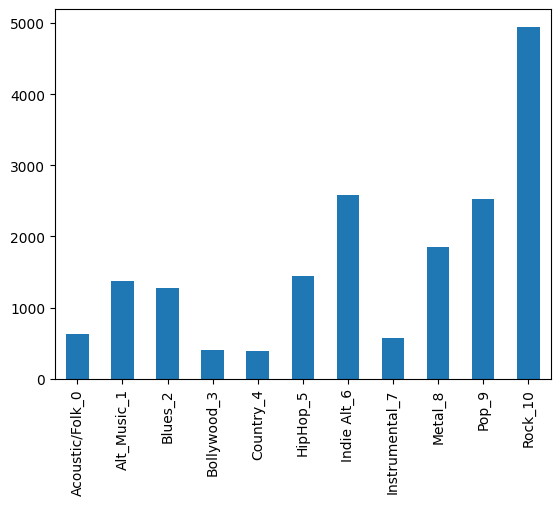

In [30]:
class_name_mapping = {i: name for i, name in enumerate(submission_csv.columns)}
class_counts = train_csv[['Class']].groupby('Class').size()
class_counts.index = pd.Index([class_name_mapping[class_id] for class_id in class_counts.index])
print("Количество объектов данного класса в тренировочном датасете:")
class_counts.plot.bar();

Видим несбалансированные классы, вспоминаем как это может повлиять на Log Loss, будем учитывать это при составлении тестовой и валидационной выборок

In [31]:
print(f"Отношение размера тестового датасета к тренировочному: {len(test_csv) / len(train_csv)}")

Отношение размера тестового датасета к тренировочному: 0.42859524338741944


Понимаем, что наши модели учится на данных примерно вдвое больших чем применяются, это важно для моделей, которые работают лучше при большом количестве данных, чтобы не переоценить их качество из-за маленького теста.

##### Строим пайплайн

Теперь нам надо построить пайплайн, который позволит нам удобно сравнивать подходы и упростит нам жизнь при подготовке финального сабмита. А именно, нам требуется сделать автоматизацию оценки моделей и логгирование их гиперпараметров, артефактов и скоров. Поясним:
1. В соревнованиях и бизнес задачах, в которых требуется много ручного труда, валидирования гипотез и моделей, при большом числе итераций очень важно не терять успешные подходы, поэтому важно вести очень подробное всестороннее логгирование. Отдельно мы проследим, чтобы наше решение было удобно ансамблировать с решениями других участников соревнования или другими моделями, для получения лучшей генерализации, при помощи такого мощного подхода как стекинг.
2. Перед тем как отправить сабмит в тестирующую систему соревнования, которые зачастую ограничивают число попыток, или, если мы не хотим светить своим большим скором на лидерборде, а тем более в бизнесе, когда деплой некачественной модели означает непредвиденную потерю ресурсов, очень важно иметь четкое представление о ее перформансе, причем представление должно хорошо коррелировать с оценкой соревнования или бизнес-метриками.

С учетом размеров тестового и тренировочного датасетов, отщепим от трейна кусочек ~3k записей для локального теста, и разобьем на 3 кроссвалидационные выборки в отношении 2:1 (10000:5000) стратифицированным образом (с сохранением пропорций размеров классов). \
**Важно! Индексы разбиения надо сохранить в виде файла, который можно шерить в рамках гипотетической команды в соревновании. Просто случайного сида недостаточно, так как его применение может быть платформозависимым.**

In [49]:
import pickle
import os
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold

filename = 'indices.pckl'
if os.path.exists(filename):
    with open(filename, 'rb') as f:
        indices = pickle.load(f)
else:
    indices = {}
    indices['train_indices'], indices['test_indices'] = train_test_split(
        np.arange(len(train_csv)),
        test_size=2996,
        stratify=train_csv['Class'],
        shuffle=True,
        random_state=0xBA0BAB
    )

    train_df = train_csv.iloc[indices['train_indices']]
    cv_splitter = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=0xBED
    )
    indices['cv_iterable'] = []
    for train_indices, val_indices in cv_splitter.split(train_df.drop('Class', axis=1), train_df['Class']):
        indices['cv_iterable'].append(
            (train_indices, val_indices)
        )
    with open(filename, 'wb+') as f:
        pickle.dump(indices, f)

In [33]:
train_indices = indices['train_indices']
test_indices = indices['test_indices']
cv_iterable = indices['cv_iterable']
X_train = train_csv.iloc[train_indices].drop('Class', axis=1)
y_train = train_csv.iloc[train_indices]['Class']
X_test = train_csv.iloc[test_indices].drop('Class', axis=1)
y_test = train_csv.iloc[test_indices]['Class']

**7. (2 балла)** Загрузите в Контест решение седьмой задачи (см. файл `src.py`).

In [54]:
from sklearn.metrics import average_precision_score, log_loss
from sklearn.metrics import balanced_accuracy_score, log_loss, make_scorer

logger = Logger('./logs')
scorer = ExperimentHandler(
    X_train, y_train, X_test, y_test, cv_iterable, logger,
    metrics={
        'balanced_accuracy': make_scorer(balanced_accuracy_score),
        'neg_log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True)
    }
)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


В качестве тестовой модели будем использовать логистическую регрессию с самыми базовыми гиперпараметрами и SoftMax'ом.

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

log_reg_pipeline = Pipeline(
    [
        (
            'extract numeric features',
            ColumnTransformer(
                [
                    (
                        'drop words',
                        'drop',
                        ['Artist Name', 'Track Name']
                    )
                ],
                remainder='passthrough'
            )
        ),
        (
            'fill missing values',
            SimpleImputer(strategy='mean')
        ),
        (
            'normalize features',
            StandardScaler()
        ),
        (
            'estimator',
            LogisticRegression(multi_class='multinomial', max_iter=10000, random_state=0x5EED)
        )
    ]
)

##### Тестируем базовые модели

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sys

tree_pipeline = Pipeline(
    [
        (
            'extract numeric features',
            ColumnTransformer(
                [
                    (
                        'drop words',
                        'drop',
                        ['Artist Name', 'Track Name']
                    )
                ],
                remainder='passthrough'
            )
        ),
        (
            'fill missing values',
            SimpleImputer(strategy='constant', fill_value=X_train.apply(pd.to_numeric, errors='coerce').max().max())
        ),
        (
            'estimator',
            DecisionTreeClassifier(max_depth=10, random_state=0x5EED)
        )
    ]
)

forest_pipeline = Pipeline(
    [
        (
            'extract numeric features',
            ColumnTransformer(
                [
                    (
                        'drop words',
                        'drop',
                        ['Artist Name', 'Track Name']
                    )
                ],
                remainder='passthrough'
            )
        ),
        (
            'fill missing values',
            SimpleImputer(strategy='constant', fill_value=X_train.apply(pd.to_numeric, errors='coerce').max().max())
        ),
        (
            'estimator',
            RandomForestClassifier(n_estimators=200, random_state=0x5EED)
        )
    ]
)

In [55]:
scorer.run(tree_pipeline, name='tree_1')
scorer.run(forest_pipeline, name='forest')
scorer.logger.leaderboard

<ipython-input-46-603676d93280>:37: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_series = pd.Series(name=name)


KeyError: 'tree_1'

Можно пронаблюдать, что ни дерево, ни лес не побеждают линейную регрессию. Зато можно их скомбинировать, усредняя подобно лесу или при помощи стекинга — это еще один хороший метод ансамблирования. Поскольку мы написали экспериментальны пайплайн так, чтобы это было просто устроить, воспользуемся этим.

In [56]:
class AverageTestClassifier:
    def __init__(self, *names, experiment_handler):
        _, stacking_predicitons_test = experiment_handler.get_stacking_predictions(names)
        self.test_predictions = sum(
            stacking_predicitons_test.loc[:, stacking_predicitons_test.columns.str.startswith(name)].values for name in names
        ) / len(names)

    def fit(self, X, y):
        return self

    def predict(self, X):
        return np.argmax(self.test_predictions, axis=1)

    def predict_proba(self, X):
        return self.test_predictions

In [57]:
estimator = AverageTestClassifier('logreg', 'forest', experiment_handler=scorer)
with scorer.logger.run(name='forest+logreg_averaging') as run:
    scorer.score_test(estimator, metrics=scorer.get_metrics(estimator), run=run)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/logreg/cv_stacking_prediction.npy'

In [58]:
scorer.logger.leaderboard

""
id


Как видим усреднять плохой предиктор с хорошим может нанести вред качеству модели. Но стекинг с линейной моделью в качестве финального эстиматора исправляет эту ситуацию, так как разным предикторам даются разные веса.

In [ ]:
class StackingCVClassifier:
    def __init__(self, *names, base_estimator, experiment_handler):
        self.stacking_predictions_train, self.stacking_predictions_test = experiment_handler.get_stacking_predictions(names)
        self.base_estimator = base_estimator

    def fit(self, X, y):
        X_train_with_stacking_predictions = pd.concat([X, self.stacking_predictions_train], axis=1)
        return self.base_estimator.fit(X_train_with_stacking_predictions, y)

    def predict(self, X):
        X_test_with_stacking_predictions = pd.concat([X, self.stacking_predictions_test], axis=1)
        return self.base_estimator.predict(X_test_with_stacking_predictions)

    def predict_proba(self, X):
        X_test_with_stacking_predictions = pd.concat([X, self.stacking_predictions_test], axis=1)
        return self.base_estimator.predict_proba(X_test_with_stacking_predictions)

In [ ]:
estimator = StackingCVClassifier('tree', 'forest', base_estimator=log_reg_pipeline, experiment_handler=scorer)
with scorer.logger.run(name='forest+tree_stacking_with_logreg') as run:
    estimator.fit(X_train, y_train)
    scorer.score_test(estimator, metrics=scorer.get_metrics(estimator), run=run)

In [ ]:
scorer.logger.leaderboard

**Задание, получите при помощи фичаинжиниринга как можно более хорошее качество на тесте (и кроссвалидации) оглядываясь на получающийся лидерборд разными способами, Затем постекайте и получите еще прирост качества: поздравляем, вы готовы врываться в соревнования!**